# 2.12 Dimensionality Reduction

Ideally, one would not need to extract or select features in the input data. However, reducing the dimensionality as a separate pre-processing step may be advantageous:

1. The complexity of the algorithm depends on the number of input dimensions and size of the data.
2. If some features are unecessary, not extracting them saves computing time
3. Simpler models are more robust on small datasets
4. Fewer features lead to a better understanding of the data.
5. Visualization is easier in fewer dimensions.

Dimensionality reduction techniques fall into two categories:

## 1. Feature selection
* **Feature *selection*** finds the dimensions that explain the data without loss of information and ends with a smaller dimensionality of the input data. A *forward selection* approach starts with one variable that decreases the error the most and adds one by one. A *backward selection* starts with all variables and removes them one by one.


In [1]:
# Import useful modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from sklearn.decomposition import PCA

In [2]:
# Generate synthetic climate data
np.random.seed(42)  # For reproducibility

n_samples = 1000
temperature = np.random.normal(loc=15, scale=10, size=n_samples)  # Mean 15°C, std 10°C
humidity = np.random.normal(loc=75, scale=15, size=n_samples)     # Mean 75%, std 15%
# Introduce correlation: precipitation is a function of humidity plus some noise
precipitation = 0.5 * humidity + np.random.normal(loc=0, scale=10, size=n_samples)  # Correlated with humidity
wind_speed = np.random.normal(loc=10, scale=5, size=n_samples)    # Mean 10m/s, std 5m/s
# Introduce correlation: solar radiation is a function of temperature plus some noise
solar_radiation = 0.8 * temperature + np.random.normal(loc=0, scale=5, size=n_samples)  # Correlated with temperature

# Combine into a DataFrame
climate_data = pd.DataFrame({
    'Temperature (°C)': temperature,
    'Humidity (%)': humidity,
    'Precipitation (mm)': precipitation,
    'Wind Speed (m/s)': wind_speed,
    'Solar Radiation (W/m2)': solar_radiation
})
climate_data.head()

,Temperature (°C),Humidity (%),Precipitation (mm),Wind Speed (m/s),Solar Radiation (W/m2)
0,19.967142,95.990332,41.243383,0.460962,11.656245
1,13.617357,88.869505,42.989566,5.698075,10.737868
2,21.476885,75.894456,30.023029,7.931972,17.271593
3,30.230299,65.295948,29.568359,19.438438,26.547391
4,12.658466,85.473350,23.800528,12.782766,3.292481


In [3]:
# Calculate the correlation matrix
correlation_matrix = climate_data.corr()

# Display the correlation matrix with a color gradient
correlation_matrix.style.background_gradient(cmap='coolwarm')

,Temperature (°C),Humidity (%),Precipitation (mm),Wind Speed (m/s),Solar Radiation (W/m2)
Temperature (°C),1.000000,-0.040400,-0.006884,-0.013321,0.840024
Humidity (%),-0.040400,1.000000,0.599756,-0.054698,-0.044765
Precipitation (mm),-0.006884,0.599756,1.000000,-0.016022,0.003570
Wind Speed (m/s),-0.013321,-0.054698,-0.016022,1.000000,-0.000992
Solar Radiation (W/m2),0.840024,-0.044765,0.003570,-0.000992,1.000000


Which feature might we remove given these correlations?

## 2. Feature extraction
**Feature *extraction*** finds a new set of dimensions as a combination of the original dimensions. They can be supervised or unsupervised depending on the output information. Examples are **Principal Component Analysis**, **Independent Component Analysis** **Linear Discriminant Analysis**


## 3 Principal Component Analysis

PCA is an unsupervised learning method that finds the mapping from the input to a lower dimensional space with minimum loss of information. First, we will download again our GPS time series from Oregon.

Principal Component Analysis (**PCA**) identifies the axis that accounts for the largest amount of variance in the data. 

Let: $\mathbf{Y} = \mathbf{y}_1,\cdots,\mathbf{y}_n $ be the data, measured $n$ times over multiple fields of measurements (the length of $\mathbf{y})$. 

Each **column** of $\mathbf{Y}$ represents a unique observation. Each **row** of $ \mathbf{Y} $ represents a single parameter.  

To undertake PCA, we will

1. Center and standardize the data by subtracting the mean of each row of $\mathbf{Y} $.
2. Calculate the covariance matrix of the de-meaned data $\mathbf{C}  =  \frac{1}{n-1} \mathbf{Y}^{\ast}\mathbf{Y}$. By definition, the covariance matrix is positive symmetric, and thus can be diagonalized.
3. Calculate the *Singular Value Decomposition (SVD)* of the covariance matrix $\mathbf{C} $. 

As the name implies, SVD decomposes the data covariance matrix $\mathbf{C} $ into 3 terms:

$\mathbf{X} = \mathbf{U} \Sigma \mathbf{V}^T ,$

where $\mathbf{V}^T$ contains the eigenvectors, or principal components. 

Principal components are normalized, centered around zero.

The *1st principal component* eigenvector has the highest eigenvalue in the direction that has the highest variance.

To demonstrate the application of PCA, we will start with some toy data: a two-dimensional (2D) point cloud made up of 10,000 observations, each with two parameters.

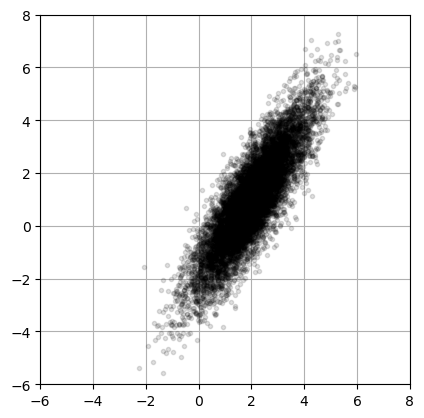

In [4]:
# Generating the toy data
xC = np.array([2, 1])      # Center of data (mean)
sig = np.array([2, 0.5])   # Principal axes
theta = np.pi/3            # Rotate cloud by pi/3
R = np.array([[np.cos(theta), -np.sin(theta)],     # Rotation matrix
              [np.sin(theta), np.cos(theta)]])
nPoints = 10000            # Create 10,000 points

# create the cloud of points by multiplying (np.matmul is also called by @)
X = R @ np.diag(sig) @ np.random.randn(2,nPoints) + np.diag(xC) @ np.ones((2,nPoints))
# plot the data
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(X[0,:],X[1,:], '.', color='k', alpha=0.125)
ax1.grid()
plt.xlim((-6, 8))
plt.ylim((-6,8))
ax1.set_aspect('equal')

### *Step 1*: subtract the mean

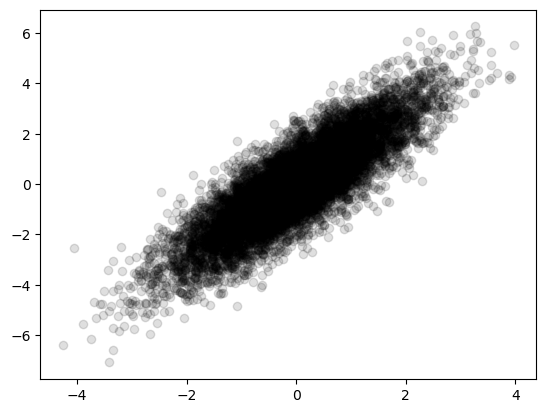

In [5]:
## Remove the mean of the data
Xavg = np.mean(X, axis=1)                 # Compute mean
B = X - np.tile(Xavg,(nPoints,1)).T       # Mean-subtracted data

plt.scatter(B[0,:],B[1,:], color='k', alpha=0.125)

### *Step 2*: Determine the SVD of the covariance matrix

In [6]:
# Find principal components (SVD): 
# use the option full_matrices =0 will calculate the covariance of B
# Here, we transpose B so that each observation is on a row

U, S, VT = np.linalg.svd(B.T,full_matrices=0)

### *Step 3*: explore the outcomes

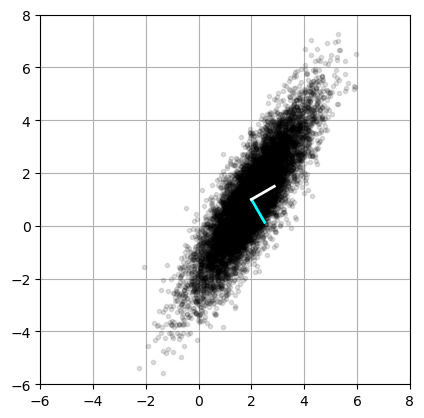

In [7]:

fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.plot(X[0,:],X[1,:], '.', color='k', alpha=0.125)   # Plot data to overlay PCA
ax2.grid()
plt.xlim((-6, 8))
plt.ylim((-6,8))
ax2.set_aspect('equal')

# Plot eigenvectors VT[:,0] and VT[:,1]
ax2.plot(np.array([Xavg[0], Xavg[0]+VT[0,0]]),
         np.array([Xavg[1], Xavg[1]+VT[1,0]]),'-',color='cyan',linewidth=2)
ax2.plot(np.array([Xavg[0], Xavg[0]+VT[0,1]]),
         np.array([Xavg[1], Xavg[1]+VT[1,1]]),'-',color='white',linewidth=2)

plt.show()

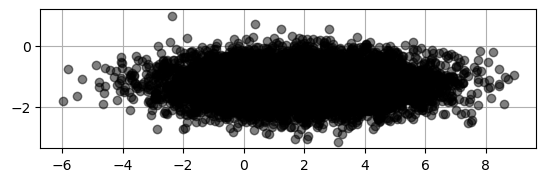

In [8]:
# Let us project the original data
# Projecting the data onto the right singular vectors

projected = X.T.dot(VT.T)

plt.scatter(projected[:,0], projected[:,1], c='k', alpha=0.5)
ax = plt.gca()
ax.set_axisbelow(True)
ax.grid()
ax.set_aspect('equal')


### 3.2 PCA on Climate Data



Explained variance ratio: [0.36980642 0.31925119]


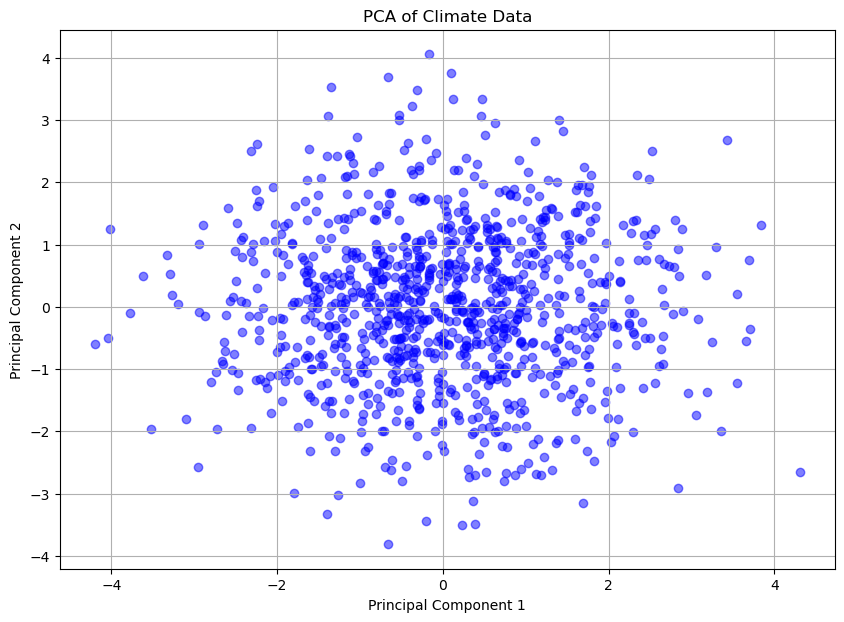

In [9]:
from sklearn.preprocessing import StandardScaler

# Standardize the data before applying PCA

scaler = StandardScaler()
climate_data_scaled = scaler.fit_transform(climate_data)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
climate_pca = pca.fit_transform(climate_data_scaled)

# Display the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Plot the PCA results
plt.figure(figsize=(10, 7))
plt.scatter(climate_pca[:, 0], climate_pca[:, 1], c='blue', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Climate Data')
plt.grid(True)
plt.show()

*SVD* can be computationally intensive for larger dimensions.

It is recommended to use a **randomized PCA** to approximate the first principal components. Scikit-learn automatically switches to randomized PCA in either the following happens: data size > 500, number of vectors is > 500 and the number of PCs selected is less than 80% of either one.

### 3.3 PCA on geospatial and temporal data
Principal Component Analysis (PCA) to spatial-temporal datasets yields 2 important dimensions: 

* **Empirical Orthogonal Functions**: 
EOFs are the eigenvectors obtained from the covariance matrix of the dataset. Each EOF corresponds to a spatial pattern that explains a portion of the total variance in the data. In climate science, EOFs help identify dominant patterns like atmospheric circulation modes or temperature anomalies.


* **Principal Components (PCs)**:
The time series associated with each EOF is called a principal component. PCs show how the amplitude of the corresponding EOF varies over time.

Together, EOFs and PCs describe the spatial-temporal variability of the dataset.





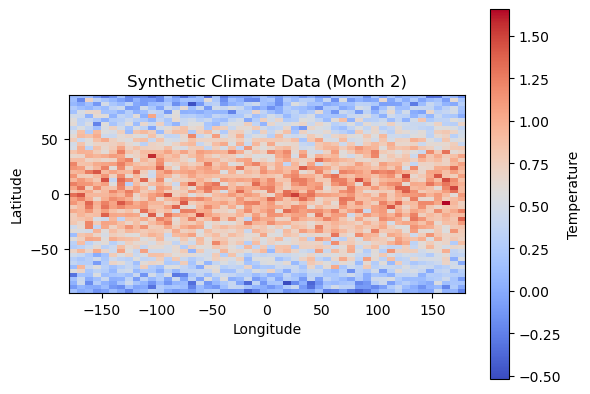

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Define the spatial grid
lat_points = 50
lon_points = 50
latitudes = np.linspace(-90, 90, lat_points)  # From South Pole to North Pole
longitudes = np.linspace(-180, 180, lon_points)  # Full range of longitudes

# Create a meshgrid for latitude and longitude
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# Step 2: Generate the latitudinal temperature gradient
# Assume temperatures decrease linearly from the equator to the poles
latitudinal_gradient = np.cos(np.radians(lat_grid))  # Cosine function for smooth transition
latitudinal_gradient = latitudinal_gradient / np.max(latitudinal_gradient)  # Normalize


# Step 3: Generate the seasonal cycle
time_steps = 360  # 30 years of monthly data
months = np.arange(time_steps) % 12  # Months from 0 to 11
seasonal_cycle = np.sin(2 * np.pi * months / 12)  # 12-month cycle


# Step 4: Introduce a climate trend
# Simulate a small temperature increase over 30 years
trend = np.linspace(0, 0.5, time_steps)  # Temperature increases by 0.5 units over 30 years

# Step 5: Combine latitudinal gradient and seasonal cycle
# Initialize the data array
data = np.zeros((time_steps, lat_points, lon_points))

for t in range(time_steps):
    # Temperature at each time step is the product of latitudinal gradient and seasonal cycle
    data[t] = latitudinal_gradient * seasonal_cycle[t] + trend[t]

# Step 6: Add random noise to simulate variability
noise_level = 0.2  # Adjust the noise level as needed
random_noise = noise_level * np.random.randn(time_steps, lat_points, lon_points)
data += random_noise

# Visualize the synthetic climate data
plt.imshow(data[3], extent=[-180, 180, -90, 90], cmap='coolwarm')
plt.title('Synthetic Climate Data (Month 2)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Temperature')
plt.show()


### PCA

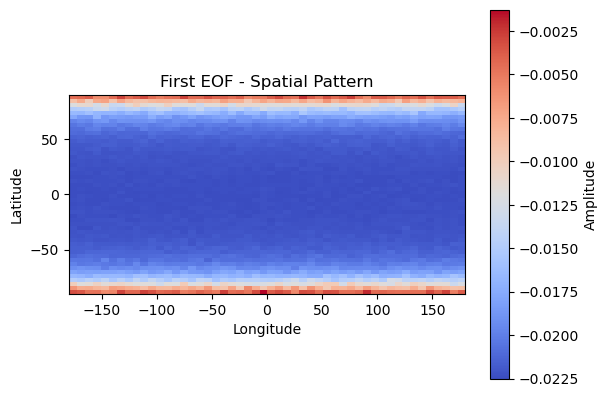

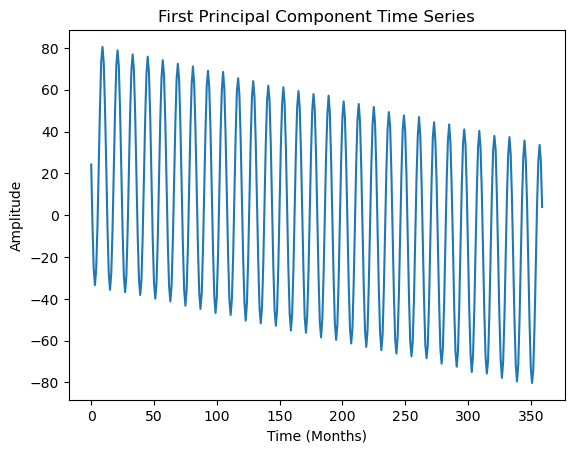

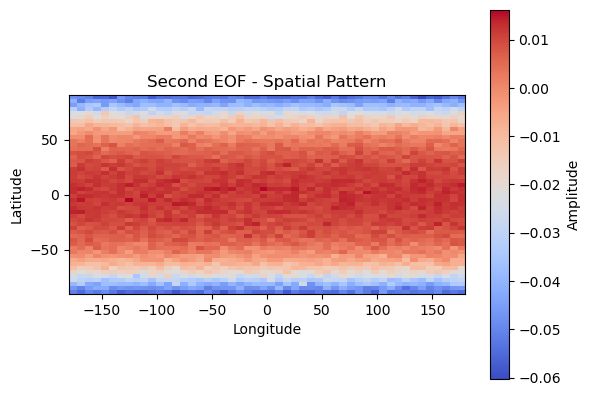

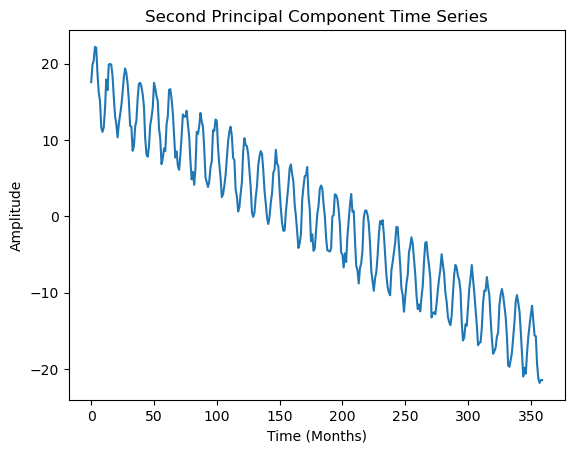

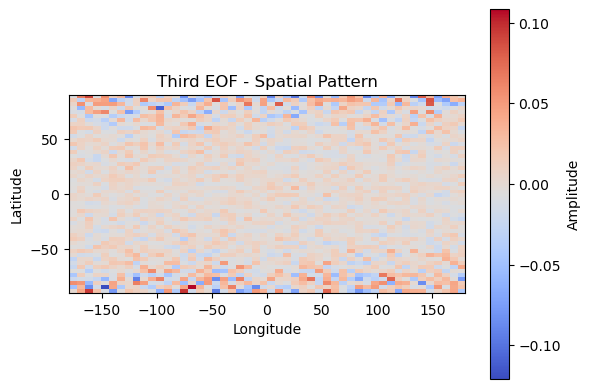

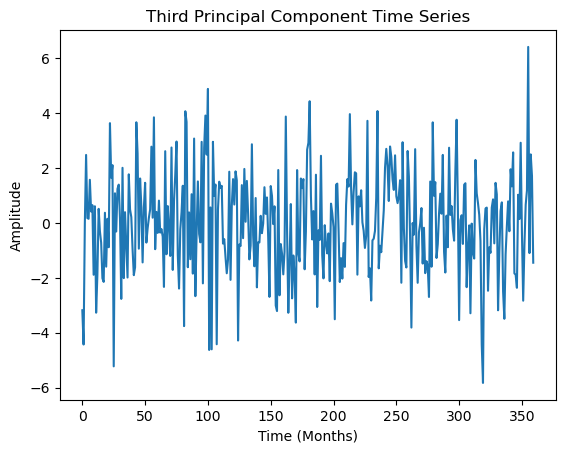

Explained Variance Ratios: [0.72902451 0.0452766  0.00142444 0.00138207 0.00137434]


In [11]:

# Step 7: Reshape data for PCA
data_reshaped = data.reshape(time_steps, lat_points * lon_points)

# Step 8: Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data_reshaped)

# Step 9: Apply PCA
pca = PCA(n_components=5)
principal_components = pca.fit_transform(data_standardized)

# Step 10: Interpret Results
# Reshape the principal components back to spatial dimensions for plotting
eofs = pca.components_.reshape(5, lat_points, lon_points)

# Plot the first EOF (Spatial Pattern)
plt.imshow(eofs[0], extent=[-180, 180, -90, 90], cmap='coolwarm')
plt.title('First EOF - Spatial Pattern')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Amplitude')
plt.show()

# Plot the corresponding time series of the first principal component
plt.plot(principal_components[:, 0])
plt.title('First Principal Component Time Series')
plt.xlabel('Time (Months)')
plt.ylabel('Amplitude')
plt.show()

# Plot the second EOF (Spatial Pattern)
plt.imshow(eofs[1], extent=[-180, 180, -90, 90], cmap='coolwarm')
plt.title('Second EOF - Spatial Pattern')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Amplitude')
plt.show()

# Plot the corresponding time series of the second principal component
plt.plot(principal_components[:, 1])
plt.title('Second Principal Component Time Series')
plt.xlabel('Time (Months)')
plt.ylabel('Amplitude')
plt.show()


# Plot the third EOF (Spatial Pattern)
plt.imshow(eofs[2], extent=[-180, 180, -90, 90], cmap='coolwarm')
plt.title('Third EOF - Spatial Pattern')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Amplitude')
plt.show()

# Plot the corresponding time series of the third principal component
plt.plot(principal_components[:, 2])
plt.title('Third Principal Component Time Series')
plt.xlabel('Time (Months)')
plt.ylabel('Amplitude')
plt.show()


# Explained variance ratios
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance)


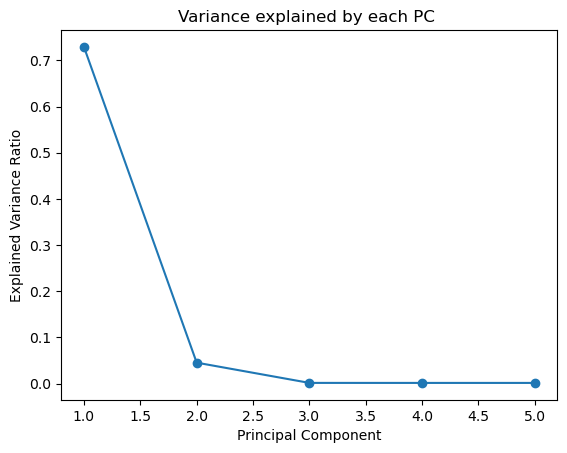

In [12]:
# Plot the scree plot
plt.plot(np.arange(1, 6), explained_variance, 'o-')
plt.title('Variance explained by each PC ')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()


It is noted here that there is no good separatation between the first two components. Here are some limitations in using PCA for geospatial-temporal data.

### 1. **Correlation Structure in Geospatial-Temporal Data**
   - **Spatial and Temporal Autocorrelation**: Geospatial data often exhibits strong spatial and temporal autocorrelation—nearby locations and consecutive time points tend to be similar. This can make it challenging for PCA to separate patterns, as ***PCA is based on the assumption that components are linearly uncorrelated***. However, in geospatial-temporal data, the patterns are often interdependent, which can result in components that do not separate spatial and temporal influences cleanly.
   - **Smooth Transitions**: Many geospatial-temporal processes (e.g., climate variables) change smoothly over space and time. These gradual transitions may not produce distinct, orthogonal components when applying PCA, as the variance is spread across broad regions or time spans rather than concentrated in distinct patterns.

### 2. **Mixing of Spatial and Temporal Variance**
   - **Spatial and Temporal Dynamics Interact**: In geospatial-temporal datasets, spatial variability and temporal variability are often intertwined. For example, seasonal patterns might dominate both spatial and temporal dimensions, leading PCA to pick components that capture a mix of spatial and temporal variance, rather than separating them into different components. The result is components that may reflect a combination of both dimensions, but not in a way that provides clear separation.
   - **Complex, Non-linear Interactions**: Many geospatial-temporal processes are driven by non-linear interactions (e.g., atmospheric processes, hydrology). PCA, being a linear method, is not well-suited to capturing non-linear relationships, leading to components that fail to distinguish between different driving forces of the variability.

### 3. **Dominance of Global Trends**
   - **Global Trends Overwhelm Local Variations**: In geospatial-temporal data, large-scale trends (such as global warming, large climatic events) can dominate the variability, overwhelming more subtle, local patterns. PCA, which seeks to maximize the explained variance in the first few components, may focus on these global trends. As a result, the components may primarily reflect large-scale phenomena, leaving less variance to be explained by smaller, localized processes that are of interest.

### 4. **Temporal Non-stationarity**
   - **Changing Processes Over Time**: In many geospatial-temporal datasets, the underlying processes are non-stationary, meaning the dominant patterns of variability change over time. PCA assumes that the variance structure is constant, which can lead to components that reflect averaged patterns over the entire dataset but fail to capture temporal shifts in dominant processes, making interpretation difficult.

### 5. **Sensitivity to Data Preprocessing**
   - **Scaling and Centering Issues**: In geospatial-temporal data, variables often have different units, magnitudes, or scales (e.g., temperature, precipitation, vegetation indices). Proper scaling and centering of variables are crucial in PCA, but choosing an appropriate scaling method can be difficult when dealing with multiple variables or dimensions (e.g., space and time). Incorrect scaling can lead to overemphasis on one variable or dimension, causing poor separation of components.

### 6. **Dimensionality Challenges**
   - **High-Dimensional Data**: Geospatial-temporal datasets often have a very high dimensionality, with many spatial points and time steps. In such cases, PCA can struggle because the variance is spread across many dimensions, leading to components that capture small amounts of variance and are difficult to interpret. This is often referred to as the "curse of dimensionality," where the high number of variables makes it difficult to reduce the dataset to a small number of interpretable components.

### Alternatives to PCA:
   Given these limitations, PCA might not be the best tool for geospatial-temporal analysis. Alternatives include:
   - **Empirical Orthogonal Functions (EOF)**: A variant of PCA often used in geosciences, which takes into account the temporal and spatial structure more explicitly.
   - **Independent Component Analysis (ICA)**: ICA can sometimes be more effective than PCA in separating mixed signals, as it seeks statistically independent components rather than merely uncorrelated ones.
   - **Multivariate Time Series Decomposition**: Methods like seasonal-trend decomposition (STL) can help separate temporal patterns (trends, seasonality) from the spatial structure.
   - **Non-linear Methods (e.g., Kernel PCA, t-SNE, UMAP)**: These can capture more complex relationships in the data that PCA, being linear, cannot detect.

In summary, PCA often fails to cleanly separate components in geospatial-temporal data because of spatial and temporal autocorrelations, intertwined variance, dominance of global trends, and the non-stationary nature of geophysical processes.

## 4. Independent Component Analysis


**What is ICA and How Does It Differ from PCA?**
Independent Component Analysis (ICA) is a computational method for separating a multivariate signal into additive, independent non-Gaussian components. It is a type of blind source separation technique.

### Key Differences Between ICA and PCA:

PCA: Finds orthogonal axes (principal components) that maximize the variance in the data.
ICA: Seeks statistically independent components, not necessarily orthogonal, by minimizing mutual information.
Assumptions:

PCA: Assumes that the data is linearly correlated and relies on second-order statistics (covariance).
ICA: Assumes that the underlying components are statistically independent and non-Gaussian.
Results:

PCA: Components are uncorrelated but may not be independent.
ICA: Components are both uncorrelated and independent, capturing more complex underlying structures.

ICA is used to estimate sources given noisy measurements. It is frequently used in Geodesy to isolate contributions from earthquakes and hydrology. 

### Advantages of ICA in Geosciences:

* **Blind Source Separation**: ICA can separate mixed signals into their original sources without prior knowledge, which is useful when the underlying processes are unknown.

* **Non-Gaussian Signals**: Many geophysical processes generate non-Gaussian data (e.g., precipitation events, seismic signals), where ICA can be more effective than PCA.

* **Independent Components**: Identifying independent factors can help in understanding and modeling complex geoscientific phenomena that are driven by multiple independent sources.

In [13]:
from scipy import signal
from sklearn.decomposition import FastICA

# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

# create 3 source signals
s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal


S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise
S /= S.std(axis=0)  # Standardize data

print(S)



[[ 0.495126    0.07841108 -1.31840023]
 [ 0.64019598  1.34570272 -1.94657351]
 [ 0.28913069  0.9500949  -1.646886  ]
 ...
 [-0.38561943 -0.71624672  1.34043406]
 [-0.50777458 -1.24052539  1.74176784]
 [-0.5550078  -0.90265774 -1.54534953]]


In [14]:
# Mix data
# create 3 signals at 3 receivers:
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations
# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
print(A_,A)
# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components


[[ 1.01396018  1.02993002 -0.94915864]
 [ 1.9826966   0.98533885 -0.47232592]
 [ 0.99746591  2.05242661 -1.37841317]] [[1.  1.  1. ]
 [0.5 2.  1. ]
 [1.5 1.  2. ]]


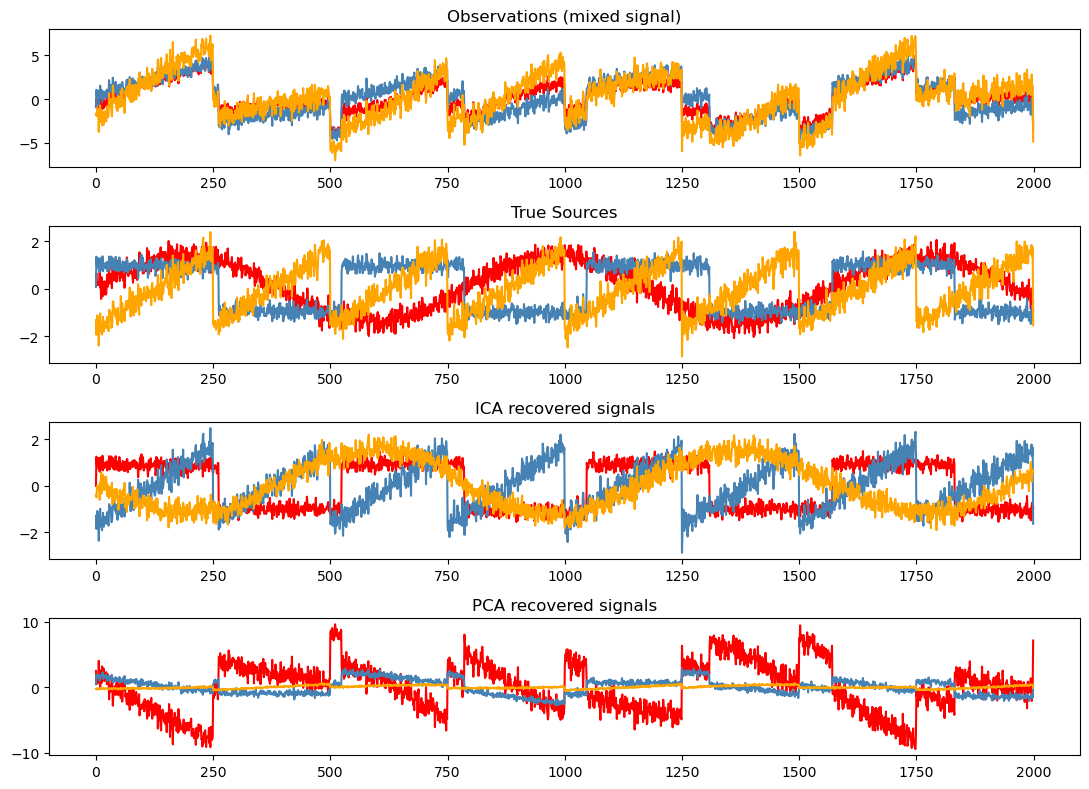

In [15]:
plt.figure(figsize=(11,8))
models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals', 
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']
for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
plt.tight_layout()
plt.show()

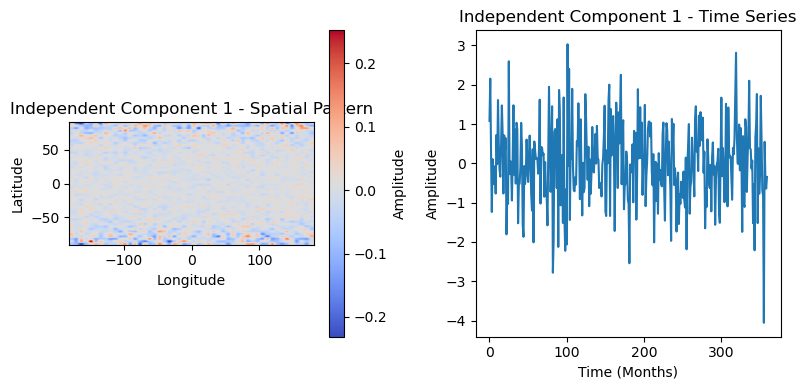

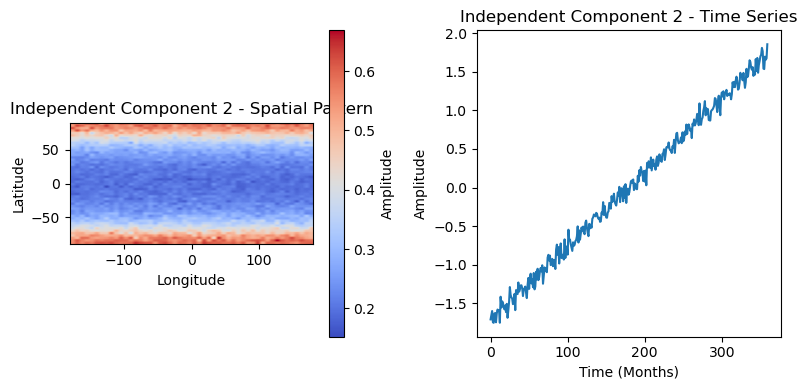

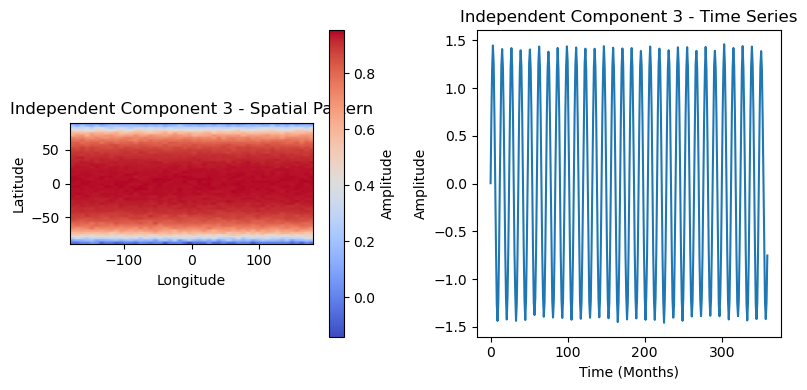

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler

# # Step 1: Define the spatial grid
# lat_points = 50
# lon_points = 50
# latitudes = np.linspace(-90, 90, lat_points)
# longitudes = np.linspace(-180, 180, lon_points)
# lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# # Step 2: Generate the latitudinal temperature gradient
# latitudinal_gradient = np.cos(np.radians(lat_grid))
# latitudinal_gradient = latitudinal_gradient / np.max(latitudinal_gradient)

# # Step 3: Generate the seasonal cycle
# time_steps = 360  # 30 years of monthly data
# months = np.arange(time_steps) % 12
# seasonal_cycle = np.sin(2 * np.pi * months / 12)

# # Step 4: Introduce a climate trend
# trend = np.linspace(0, 0.5, time_steps)

# # Step 5: Combine patterns
# data = np.zeros((time_steps, lat_points, lon_points))
# for t in range(time_steps):
#     data[t] = latitudinal_gradient * seasonal_cycle[t] + trend[t]

# # Step 6: Add random noise
# noise_level = 0.2
# random_noise = noise_level * np.random.randn(time_steps, lat_points, lon_points)
# data += random_noise

# # Step 7: Reshape data for ICA
# data_reshaped = data.reshape(time_steps, lat_points * lon_points)

# Step 8: Center and whiten the data
scaler = StandardScaler()
data_whitened = scaler.fit_transform(data_reshaped)

# Step 9: Apply ICA
n_components = 3
ica = FastICA(n_components=n_components, random_state=0, max_iter=1000)
S_ = ica.fit_transform(data_whitened)  # Reconstructed signals
A_ = ica.mixing_  # Estimated mixing matrix

# Step 10: Reshape independent components for plotting
ICs = A_.T.reshape(n_components, lat_points, lon_points)

# Step 11: Plot the independent components
for i in range(n_components):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(ICs[i], extent=[-180, 180, -90, 90], cmap='coolwarm')
    plt.title(f'Independent Component {i+1} - Spatial Pattern')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(label='Amplitude')

    plt.subplot(1, 2, 2)
    plt.plot(S_[:, i])
    plt.title(f'Independent Component {i+1} - Time Series')
    plt.xlabel('Time (Months)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()


## 6. Other Techniques


1. Random Projections
https://scikit-learn.org/stable/modules/random_projection.html
2. Multidimensional Scaling
3. Isomap
4. t-Distributed stochastic neighbor embedding
5. Linear discriminant analysis